In [1]:
### Function Imports
from OptionsFunctions import import_fx_data, plot_forex, daily_returns
import numpy as np
from scipy.stats import norm
import pandas as pd


In [2]:
### Call Function to Load in Rate Data (Get Spot Price S_0)
all_forex_pairs = [
        'EURUSD=X', 'GBPUSD=X', 'USDJPY=X', 'USDCHF=X', 'AUDUSD=X', 'NZDUSD=X',
        'USDCAD=X', 'EURGBP=X', 'EURJPY=X', 'EURCHF=X', 'EURAUD=X', 'EURNZD=X',
        'EURCAD=X', 'GBPAUD=X', 'GBPJPY=X', 'GBPCHF=X', 'AUDJPY=X', 'AUDCHF=X',
        'AUDNZD=X', 'NZDJPY=X', 'NZDCHF=X', 'CADJPY=X', 'CADCHF=X', 'CHFJPY=X'
    ]
pair = 'USDEUR=X'
start_date = '2021-01-01'
forex_data = import_fx_data(pair, start_date)
print(forex_data) 
# Get the Spot Price (Most recent FX rate value)
S_0 = forex_data[pair].iloc[-1]  # Extract the last value from the column 'USDEUR=X'
print('The Spot Price is:', round(S_0, 4))
K = 0.9500
print('The pre-determined Strike Price is:', K)


[*********************100%%**********************]  1 of 1 completed

          Date  USDEUR=X
0   2021-01-01   0.82100
1   2021-01-04   0.81628
2   2021-01-05   0.81622
3   2021-01-06   0.81299
4   2021-01-07   0.81030
..         ...       ...
907 2024-06-25   0.93173
908 2024-06-26   0.93374
909 2024-06-27   0.93632
910 2024-06-28   0.93384
911 2024-07-01   0.93050

[912 rows x 2 columns]
The Spot Price is: 0.9305
The pre-determined Strike Price is: 0.95


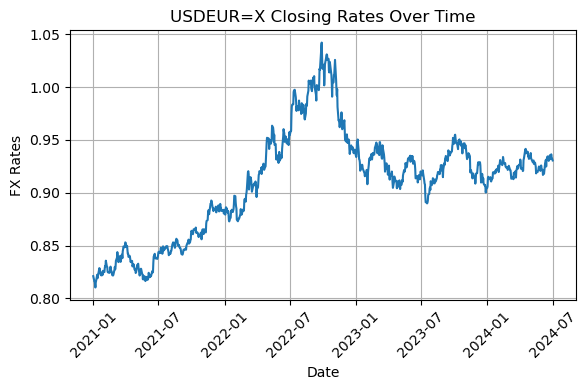

In [3]:
### Call Function to Plot FX Data
plot_pair = ['USDEUR=X']
plot_forex(forex_data, plot_pair)

In [4]:
### Function Call to Compute Daily Returns
daily_rets = daily_returns(forex_data)
print(daily_rets)

# Define the file path where you want to save the CSV
#file_path = 'daily_returns.csv'
# Save the DataFrame to CSV
#daily_rets.to_csv(file_path, index=False)

          Date  USDEUR=X
0   2021-01-04 -0.005749
1   2021-01-05 -0.000074
2   2021-01-06 -0.003957
3   2021-01-07 -0.003309
4   2021-01-08  0.005677
..         ...       ...
906 2024-06-25 -0.004190
907 2024-06-26  0.002157
908 2024-06-27  0.002763
909 2024-06-28 -0.002649
910 2024-07-01 -0.003577

[911 rows x 2 columns]


In [5]:
### Function to compute sigma (volatility)
def compute_sigma(returns):
    if 'Date' in returns.columns:
        returns = returns.drop(columns = 'Date')
    # Sigma computation with removed date col
    sigma = np.std(returns) * np.sqrt(252)  # Annualize the volatility
    return sigma.iloc[-1]

sigma = compute_sigma(daily_rets)
print('The sigma value was computed to be:', round(sigma, 5))

The sigma value was computed to be: 0.07505


In [6]:
### Function to Build Black Scholes (BSM) Model
def black_scholes(S_0, K, r, r_f, T, sigma, option_type):
    # Compute d_1 and d_2
    d_1 = (np.log(S_0 / K) + (r - r_f + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    #print(d_1)
    d_2 = d_1 - sigma * np.sqrt(T)
    #print(d_2)
    
    # Compute Option Premium and Greeks
    if option_type == 'call':
        option_price = S_0 * np.exp(-r_f * T) * norm.cdf(d_1) - K * np.exp(-r * T) * norm.cdf(d_2)
        delta = np.exp(-r_f * T) * norm.cdf(d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(d_1))
        rho = K * T * np.exp(-r * T) * norm.cdf(d_2)

    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d_2) - S_0 * np.exp(-r_f * T) * norm.cdf(-d_1)
        delta = -np.exp(-r_f * T) * norm.cdf(-d_1)
        theta = (-S_0 * sigma * np.exp(-r_f * T) * norm.pdf(d_1) / (2 * np.sqrt(T)) 
                 - r * K * np.exp(-r * T) * norm.cdf(-d_2)
                 + r_f * S_0 * np.exp(-r_f * T) * norm.cdf(-d_1))
        rho = -K * T * np.exp(-r * T) * norm.cdf(-d_2)

    else:
        raise ValueError('Error: Incorrect Option Type, must input call or put')

    # Calculate Remaining Greeks
    gamma = np.exp(-r_f * T) * norm.pdf(d_1) / (S_0 * sigma * np.sqrt(T))
    vega = S_0 * np.exp(-r_f * T) * np.sqrt(T) * norm.pdf(d_1)

    # Probabilities
    prob_ITM_call = norm.cdf(d_1)
    prob_ITM_put = norm.cdf(-d_1)
    prob_exercise_call = norm.cdf(d_2)
    prob_exercise_put = norm.cdf(-d_2)

    # Print and explain values
    print(f"Option Type: {option_type}")
    print(f"Option Price: {option_price:.4f}")
    print(f"Delta: {delta:.4f} - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)")
    print(f"Gamma: {gamma:.4f} - Gamma measures the rate of change of Delta with respect to changes in the underlying price.")
    print(f"Theta: {theta:.4f} - Theta measures the sensitivity of the option's price to the passage of time.")
    print(f"Rho: {rho:.4f} - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.")
    print(f"Vega: {vega:.4f} - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.")
    print(f"Probability ITM (Call): {prob_ITM_call:.4f} - Probability the call option finishes In The Money.")
    print(f"Probability ITM (Put): {prob_ITM_put:.4f} - Probability the put option finishes In The Money.")
    print(f"Probability of Exercise (Call): {prob_exercise_call:.4f} - Probability the call option will be exercised.")
    print(f"Probability of Exercise (Put): {prob_exercise_put:.4f} - Probability the put option will be exercised.")

    # Return Option Premium and Greeks
    return option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put

### Call Function to Compute Option Premium and Greeks
r = 0.02
r_f = 0.01
T = 1
option_price, delta, gamma, theta, rho, vega, prob_ITM_call, prob_ITM_put, prob_exercise_call, prob_exercise_put = black_scholes(S_0, K, r, r_f, T, sigma, option_type = 'call')



Option Type: call
Option Price: 0.0230
Delta: 0.4534 - Delta represents the sensitivity of the option's price to changes in the underlying asset's price (prob option finishes ITM)
Gamma: 5.6248 - Gamma measures the rate of change of Delta with respect to changes in the underlying price.
Theta: -0.0175 - Theta measures the sensitivity of the option's price to the passage of time.
Rho: 0.3989 - Rho measures the sensitivity of the option's price to changes in the risk-free interest rate.
Vega: 0.3655 - Vega measures the sensitivity of the option's price to changes in the volatility of the underlying asset.
Probability ITM (Call): 0.4580 - Probability the call option finishes In The Money.
Probability ITM (Put): 0.5420 - Probability the put option finishes In The Money.
Probability of Exercise (Call): 0.4283 - Probability the call option will be exercised.
Probability of Exercise (Put): 0.5717 - Probability the put option will be exercised.


In [7]:
### Function to Implement the Hedge (Compute Hedge Position and hedged returns)
def hedge_position(fx_rets, delta, long_pos):
    if 'Date' in fx_rets.columns:
        fx_rets = fx_rets.drop(columns='Date')
    
    hedge_pos = -delta * long_pos
    hedged_rets = fx_rets + hedge_pos
    return hedge_pos, hedged_rets

### Call Hedged Rets Function
long_pos = 1000  # units of currency pair (not dollars)
hedge_pos, hedged_rets = hedge_position(daily_rets, delta, long_pos)
print('The computed hedge position is:', round(hedge_pos, 4))
print("Hedged Returns:")
print(hedged_rets.head())


The computed hedge position is: -453.3971
Hedged Returns:
     USDEUR=X
0 -453.402851
1 -453.397176
2 -453.401059
3 -453.400411
4 -453.391425


In [10]:
### Function to Implement Backtesting for Hedged and Unhedged Returns
def calculate_hedged_unhedged(pair, long_pos, returns, option_delta):
    # Ensure we're only using the returns data without the Date column
    if 'Date' in returns.columns:
        returns = returns.set_index('Date')
    # Debug print to check the structure of the returns dataframe
    #print("Returns DataFrame Structure:")
    #print(returns.head())

    # Select the returns for the specified pair
    pair_returns = returns[pair]

    # Compute Hedge Position: holding a protective put
    hedge_pos = -option_delta * long_pos
    #print(f"Calculated Hedge Position: {hedge_pos}")

    # Compute daily returns for the long position
    long_rets = returns * long_pos
    #print("Daily Returns for the Long Position:")
    #print(long_rets.head())

    # Compute the returns of the hedged and unhedged positions
    hedged_rets = returns + (hedge_pos / long_pos)
    #hedged_rets = returns - hedge_pos
    unhedged_rets = returns

    # Compute cumulative returns for the hedged and unhedged positions
    hedged_cumulative_rets = (1 + hedged_rets).cumprod() * long_pos
    unhedged_cumulative_rets = (1 + unhedged_rets).cumprod() * long_pos

    return hedged_cumulative_rets, unhedged_cumulative_rets

# Assuming 'daily_rets' and 'delta' are already defined
hedged_cumulative_rets, unhedged_cumulative_rets = calculate_hedged_unhedged(pair, long_pos, daily_rets, delta)
print("Hedged Cumulative Returns:")
print(hedged_cumulative_rets.tail())
print("Unhedged Cumulative Returns:")
print(unhedged_cumulative_rets.tail())


Hedged Cumulative Returns:
                 USDEUR=X
Date                     
2024-06-25  1.452990e-235
2024-06-26  7.973434e-236
2024-06-27  4.380333e-236
2024-06-28  2.382701e-236
2024-07-01  1.293869e-236
Unhedged Cumulative Returns:
               USDEUR=X
Date                   
2024-06-25  1134.872101
2024-06-26  1137.320393
2024-06-27  1140.462886
2024-06-28  1137.442143
2024-07-01  1133.373926
